In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import plotly as py
import plotly.graph_objs as go
import math

# GPU 메모리 제한하기.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                           [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 8 * 1024)])

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
print(plt.rcParams['font.family'])

['Malgun Gothic']


# 데이터 불러오기

In [2]:
df = pd.read_csv('monthly_data.csv', encoding = 'euc-kr', index_col = '시점')

df = df.drop('Unnamed: 4', axis = 1)

df

,행정구역별,종류별,"출생,사망,혼인,이혼"
시점,,,
1981.01 월,전국,출생아수(명),88151
1981.02 월,전국,출생아수(명),93556
1981.03 월,전국,출생아수(명),70421
1981.04 월,전국,출생아수(명),66093
1981.05 월,전국,출생아수(명),68940
...,...,...,...
2022.11 월,제주특별자치도,조이혼율(천명당),2.3
2022.12 월,제주특별자치도,조이혼율(천명당),2.2
2023.01 월,제주특별자치도,조이혼율(천명당),1.7


In [3]:
df.columns

Index(['행정구역별', '종류별', '출생,사망,혼인,이혼'], dtype='object')

# 사용할 데이터만 뽑아내기(전국 데이터)

In [4]:
is_all = df['행정구역별'] == '전국'

allData = df[is_all]

allData

,행정구역별,종류별,"출생,사망,혼인,이혼"
시점,,,
1981.01 월,전국,출생아수(명),88151
1981.02 월,전국,출생아수(명),93556
1981.03 월,전국,출생아수(명),70421
1981.04 월,전국,출생아수(명),66093
1981.05 월,전국,출생아수(명),68940
...,...,...,...
2022.11 월,전국,조이혼율(천명당),2
2022.12 월,전국,조이혼율(천명당),1.8
2023.01 월,전국,조이혼율(천명당),1.7


In [5]:
columns_names = df['종류별'].unique()

columns_names

array(['출생아수(명)', '조출생률(천명당)', '사망자수(명)', '조사망률(천명당)', '자연증가건수(명)',
       '자연증가율(천명당)', '혼인건수(건)', '조혼인율(천명당)', '이혼건수(건)', '조이혼율(천명당)'],
      dtype=object)

# 전국 데이터를 필요한 형태로 가공하기 

In [6]:
new_df = pd.DataFrame()

for column in columns_names:
    tmp = allData['종류별'] == column
    newDf = allData[tmp]
    newDf = newDf.rename(columns = {'출생,사망,혼인,이혼' : column})
    newDf = newDf.drop('종류별', axis = 1)
    new_df[column] = newDf[column]

new_df.index = pd.to_datetime(new_df.index, format='%Y.%m 월')

new_df = new_df.apply(pd.to_numeric, errors='coerce')
new_df

,출생아수(명),조출생률(천명당),사망자수(명),조사망률(천명당),자연증가건수(명),자연증가율(천명당),혼인건수(건),조혼인율(천명당),이혼건수(건),조이혼율(천명당)
시점,,,,,,,,,,
1981-01-01,88151,NaN,NaN,NaN,NaN,NaN,49285,NaN,1827,NaN
1981-02-01,93556,NaN,NaN,NaN,NaN,NaN,34481,NaN,1687,NaN
1981-03-01,70421,NaN,NaN,NaN,NaN,NaN,47843,NaN,2094,NaN
1981-04-01,66093,NaN,NaN,NaN,NaN,NaN,35956,NaN,2189,NaN
1981-05-01,68940,NaN,NaN,NaN,NaN,NaN,35769,NaN,2059,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-11-01,18940,4.5,30138.0,7.2,-11198.0,-2.7,17455,4.1,8498,2.0
2022-12-01,16803,3.9,33360.0,7.7,-16557.0,-3.8,19883,4.6,7821,1.8
2023-01-01,23179,5.3,32703.0,7.5,-9524.0,-2.2,17926,4.1,7251,1.7


# 결측값이 없는 년도 부터 데이터 시작 

In [7]:
new_df = new_df[24:]

new_df

,출생아수(명),조출생률(천명당),사망자수(명),조사망률(천명당),자연증가건수(명),자연증가율(천명당),혼인건수(건),조혼인율(천명당),이혼건수(건),조이혼율(천명당)
시점,,,,,,,,,,
1983-01-01,86723,NaN,23147.0,NaN,63576.0,NaN,37763,NaN,2178,NaN
1983-02-01,89422,NaN,20099.0,NaN,69323.0,NaN,35454,NaN,1970,NaN
1983-03-01,61169,NaN,22632.0,NaN,38537.0,NaN,42980,NaN,2431,NaN
1983-04-01,56581,NaN,21767.0,NaN,34814.0,NaN,36991,NaN,2309,NaN
1983-05-01,57580,NaN,18412.0,NaN,39168.0,NaN,37849,NaN,2318,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-11-01,18940,4.5,30138.0,7.2,-11198.0,-2.7,17455,4.1,8498,2.0
2022-12-01,16803,3.9,33360.0,7.7,-16557.0,-3.8,19883,4.6,7821,1.8
2023-01-01,23179,5.3,32703.0,7.5,-9524.0,-2.2,17926,4.1,7251,1.7


# 출생아수(명) 예측에 불필요한 컬럼 삭제하기 

In [8]:
columns = list(new_df.columns)
garbage_data = ['조출생률(천명당)', '조사망률(천명당)', '자연증가율(천명당)', '조혼인율(천명당)', '조이혼율(천명당)']

for column in garbage_data:
    columns.remove(column)

print(columns)

['출생아수(명)', '사망자수(명)', '자연증가건수(명)', '혼인건수(건)', '이혼건수(건)']


# 결측값(Nan) 보간하기. 뒤에서 부터 데이터를 읽으면서 비어 있는 값들을 보간한다. 

In [9]:
# 결측값 보간하기. 뒤에서 부터 데이터를 읽으면서 비어있는 값을 보간함.

interpolated_df = pd.DataFrame()
for column in columns:
    if(new_df[column].isnull().sum() != 0):
        ts = pd.Series(new_df[column], index = new_df.index)
        ts_intp_linear = ts.interpolate(method = 'time', limit_direction = 'backward')
        interpolated_df[column] = ts_intp_linear
    else:
        interpolated_df[column] = new_df[column]
        
interpolated_df = interpolated_df.apply(lambda x: x.astype(int))

interpolated_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 483 entries, 1983-01-01 to 2023-03-01
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   출생아수(명)    483 non-null    int32
 1   사망자수(명)    483 non-null    int32
 2   자연증가건수(명)  483 non-null    int32
 3   혼인건수(건)    483 non-null    int32
 4   이혼건수(건)    483 non-null    int32
dtypes: int32(5)
memory usage: 13.2 KB


# 데이터 증강하기 

In [10]:
# 기존의 데이터가 학습하기에 너무 부족하다.
# 데이터의 시작 부터 끝 까지 데이터 중간에 결측값을 하나씩 집어 넣는다.
# 그 결측값들을 시간 순서에 따라서 보간한다.

start_date = pd.to_datetime('1982-12-01')
end_date = pd.to_datetime('2023-02-01')

dates = pd.date_range(start = start_date, end = end_date, freq = 'M')
dates = dates + pd.DateOffset(months=1) - pd.DateOffset(day = 15)

empty_df = pd.DataFrame(index = dates, columns = columns)
empty_df = empty_df.fillna(0)
empty_df = empty_df.astype(int)
empty_df = empty_df.replace(0, np.nan)
empty_df = pd.concat([interpolated_df, empty_df])

In [11]:
empty_df = empty_df.sort_index()

empty_df

,출생아수(명),사망자수(명),자연증가건수(명),혼인건수(건),이혼건수(건)
1983-01-01,86723.0,23147.0,63576.0,37763.0,2178.0
1983-01-15,NaN,NaN,NaN,NaN,NaN
1983-02-01,89422.0,20099.0,69323.0,35454.0,1970.0
1983-02-15,NaN,NaN,NaN,NaN,NaN
1983-03-01,61169.0,22632.0,38537.0,42980.0,2431.0
...,...,...,...,...,...
2023-01-01,23179.0,32703.0,-9524.0,17926.0,7251.0
2023-01-15,NaN,NaN,NaN,NaN,NaN
2023-02-01,19939.0,27390.0,-7452.0,17846.0,7228.0
2023-02-15,NaN,NaN,NaN,NaN,NaN


In [12]:
empty_df.index.name = 'time'
interpolated_df = empty_df.interpolate(mathod = 'time')
interpolated_df = interpolated_df.astype(int)
max_values = interpolated_df.max()
max_value = max_values['출생아수(명)']
min_values = interpolated_df.min()
min_value = min_values['출생아수(명)']
print(interpolated_df)

            출생아수(명)  사망자수(명)  자연증가건수(명)  혼인건수(건)  이혼건수(건)
time                                                     
1983-01-01    86723    23147      63576    37763     2178
1983-01-15    88072    21623      66449    36608     2074
1983-02-01    89422    20099      69323    35454     1970
1983-02-15    75295    21365      53930    39217     2200
1983-03-01    61169    22632      38537    42980     2431
...             ...      ...        ...      ...      ...
2023-01-01    23179    32703      -9524    17926     7251
2023-01-15    21559    30046      -8488    17886     7239
2023-02-01    19939    27390      -7452    17846     7228
2023-02-15    20538    28156      -7618    18019     7741
2023-03-01    21138    28922      -7784    18192     8255

[965 rows x 5 columns]


# 데이터 스케일링 

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

scaler = MinMaxScaler()
scale_cols = columns
scaled = scaler.fit_transform(interpolated_df[scale_cols])
scaled

array([[0.96283342, 0.21789827, 0.93679893, 0.65336197, 0.01535395],
       [0.98140982, 0.162367  , 0.96839396, 0.62195818, 0.00767698],
       [1.        , 0.10683574, 1.        , 0.59058158, 0.        ],
       ...,
       [0.04318429, 0.37250401, 0.15568777, 0.11183012, 0.38813021],
       [0.05143282, 0.40041539, 0.15386223, 0.11653389, 0.42599838],
       [0.05969512, 0.42832677, 0.15203669, 0.12123766, 0.46394036]])

In [14]:
df = pd.DataFrame(scaled, columns = scale_cols, index = interpolated_df.index)
df

,출생아수(명),사망자수(명),자연증가건수(명),혼인건수(건),이혼건수(건)
time,,,,,
1983-01-01,0.962833,0.217898,0.936799,0.653362,0.015354
1983-01-15,0.981410,0.162367,0.968394,0.621958,0.007677
1983-02-01,1.000000,0.106836,1.000000,0.590582,0.000000
1983-02-15,0.805464,0.152966,0.830720,0.692895,0.016978
1983-03-01,0.610942,0.199133,0.661439,0.795209,0.034030
...,...,...,...,...,...
2023-01-01,0.087801,0.566098,0.132902,0.114005,0.389828
2023-01-15,0.065493,0.469283,0.144295,0.112918,0.388942
2023-02-01,0.043184,0.372504,0.155688,0.111830,0.388130


In [15]:
born = df['출생아수(명)'].values.tolist()
born

[0.9628334182514219,
 0.9814098238752943,
 1.0,
 0.8054641347305801,
 0.6109420399619935,
 0.579352511050827,
 0.5477629821396605,
 0.554634462055385,
 0.5615197124719427,
 0.5435629793855603,
 0.525606246299178,
 0.5440587174155525,
 0.5625111885319269,
 0.5691072584309892,
 0.5757170988308845,
 0.5799997245899834,
 0.5842823503490823,
 0.6132830251036231,
 0.642297470358997,
 0.6397086162023713,
 0.6371197620457456,
 0.6207741775568377,
 0.60442859306793,
 0.7281565430534709,
 0.851898263539845,
 0.9062779713298174,
 0.9606576791197897,
 0.7147027637395172,
 0.46876161886007794,
 0.45584488907861587,
 0.44294192979798674,
 0.43730979495724265,
 0.43167766011649844,
 0.4216114240074912,
 0.411558958399317,
 0.4388245500488853,
 0.4661039121992867,
 0.4737052286591663,
 0.4813203156198791,
 0.48857736955893094,
 0.49584819399881574,
 0.5243118192208651,
 0.5527892149437476,
 0.525730180806676,
 0.4986849171704375,
 0.4760186727991297,
 0.45336619892865504,
 0.613035156088627,
 0.772717

In [16]:
window_size = 5
x = []
y = []

for i in range(len(born) - window_size):
    x.append([born[i+j] for j in range(window_size)])
    y.append(born[window_size + i])

In [17]:
x = np.asarray(x)
y = np.asarray(y)
print(len(y))

960


# 학습 데이터와 검증 데이터 분리

In [18]:
train_test_split = 200

x_train = x[:train_test_split, :]
y_train = y[:train_test_split]

x_test = x[train_test_split:, :]
y_test = y[train_test_split : ]

# LSTM 모델 생성 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    LSTM(128, input_shape = (x_train.shape[1], 1, )),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'relu')
])

In [20]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# 10번 epoch 동안 loss 개선이 없다면 학습 종료
earlystopping = EarlyStopping(monitor = 'loss', patience = 20)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x_train, y_train, epochs = 200, callbacks = [earlystopping], batch_size = 2)
history

Epoch 1/200
100/100 [==============================] - 4s 3ms/step - loss: 0.0270 - mse: 0.0270
Epoch 2/200
100/100 [==============================] - 0s 3ms/step - loss: 0.0124 - mse: 0.0124
Epoch 3/200
100/100 [==============================] - 0s 3ms/step - loss: 0.0110 - mse: 0.0110
Epoch 4/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0100 - mse: 0.0100
Epoch 5/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0095 - mse: 0.0095
Epoch 6/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0089 - mse: 0.0089
Epoch 7/200
100/100 [==============================] - 0s 5ms/step - loss: 0.0082 - mse: 0.0082
Epoch 8/200
100/100 [==============================] - 0s 5ms/step - loss: 0.0075 - mse: 0.0075
Epoch 9/200
100/100 [==============================] - 0s 5ms/step - loss: 0.0057 - mse: 0.0057
Epoch 10/200
100/100 [==============================] - 0s 5ms/step - loss: 0.0065 - mse: 0.0065
Epoch 11/200
100/100 [=================

24/24 [==============================] - 0s 2ms/step


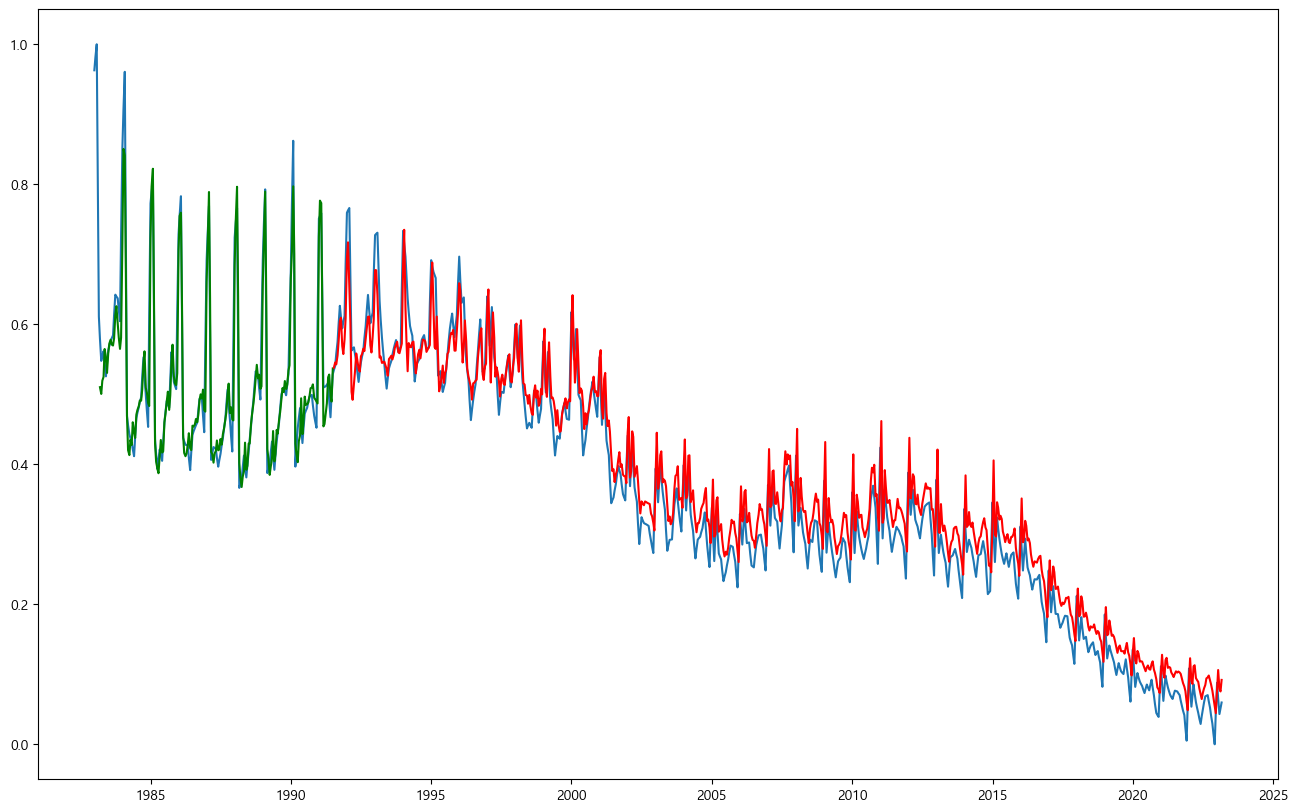

In [22]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

index_list = list(interpolated_df.index)
train_index = index_list[window_size : train_test_split + window_size]
test_index = index_list[train_test_split + window_size:]

plt.figure(figsize = (16, 10))
plt.plot(index_list, born)

split_pt = train_test_split + window_size
plt.plot(train_index, train_predict[:,0], color = 'g')
plt.plot(test_index, test_predict[:,0], color = 'r')

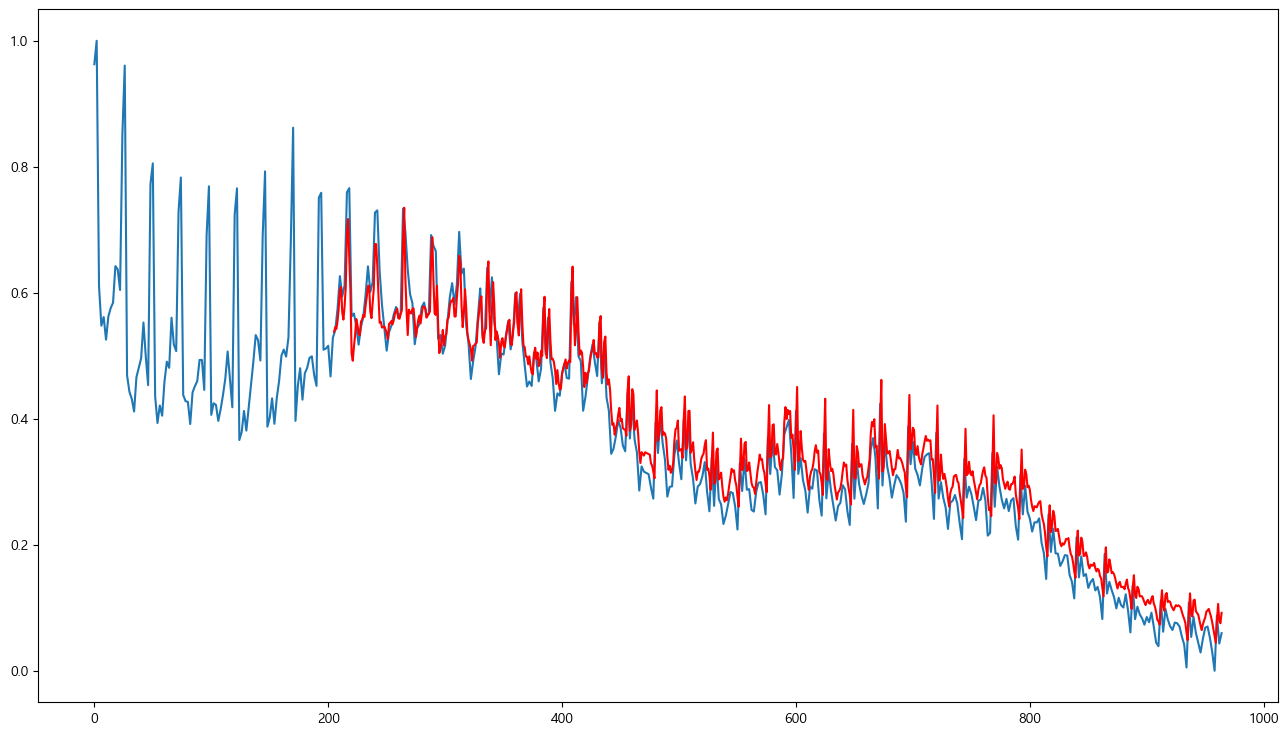

In [23]:
plt.figure(figsize = (16, 9))
plt.plot(born)
plt.plot(np.arange(train_test_split + window_size, len(y) + window_size), test_predict[:, 0], color = 'r')

In [24]:
test_predict_df = pd.DataFrame(test_predict[:, 0], columns=['예상 출생아수'])
test_predict_df

,예상 출생아수
0,0.538014
1,0.545341
2,0.542704
3,0.555319
4,0.575956
...,...
755,0.078673
756,0.106094
757,0.078933
758,0.075457


In [25]:
def original_value(converted_value):
    return math.floor(converted_value * (max_value - min_value) + min_value)

original_train_value = []
original_test_value = []
for i in train_predict:
    original_train_value.append(original_value(i[0]))
    
for i in test_predict:
    original_test_value.append(original_value(i[0]))

In [26]:
train_df = pd.DataFrame(original_train_value, columns=['출생아수(명)'], index = train_index)
test_df = pd.DataFrame(original_test_value, columns=['출생아수(명)'], index = test_index)
print("실제 데이터 ------------------------")
print(interpolated_df.tail())
print("예측 데이터 ------------------------")
print(test_df.tail())

실제 데이터 ------------------------
            출생아수(명)  사망자수(명)  자연증가건수(명)  혼인건수(건)  이혼건수(건)
time                                                     
2023-01-01    23179    32703      -9524    17926     7251
2023-01-15    21559    30046      -8488    17886     7239
2023-02-01    19939    27390      -7452    17846     7228
2023-02-15    20538    28156      -7618    18019     7741
2023-03-01    21138    28922      -7784    18192     8255
예측 데이터 ------------------------
            출생아수(명)
2023-01-01    22516
2023-01-15    24507
2023-02-01    22535
2023-02-15    22282
2023-03-01    23480


In [41]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, test_predict)
rmse = np.sqrt(mse)

print("RMSE : ", rmse)

RMSE :  0.03665156555589055
